In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens, collect_parameters, load_measurements
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

## Creating RecommenderSystem on MovieLens 

In [90]:
n_attrs=20
max_iter=100
n_clusters=20

In [91]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [92]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Calculating embeddings...
Calculated embeddings.


/opt/conda/envs/rsenv2/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [93]:
# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Calculating clusters...


/opt/conda/envs/rsenv2/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  ConvergenceWarning,


Calculated clusters.


In [95]:
# Create user clusters based off how often they interacted with the same item
print('Calculating clusters...')
co_occurence_matrix = binary_ratings_matrix @ binary_ratings_matrix.T
print(co_occurence_matrix.shape)

# Matrix factorize co_occurence_matrix to get embeddings
nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter)
W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

# cluster W_topics
cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit_predict(W_topics)

print('Calculated clusters.')

Calculating clusters...
(943, 943)


/opt/conda/envs/rsenv2/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  ConvergenceWarning,


Calculated clusters.


In [103]:
num_users = len(user_representation)
num_items = len(item_representation)

# create user_pairs by pairing users only with others that are not in the same cluster
user_pairs = []
for u_idx in range(num_users):
    for v_idx in range(num_users):
        if cluster_ids[u_idx] != cluster_ids[v_idx]:
            user_pairs.append((u_idx, v_idx))

# All possible user pairs
# user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

# Simulation

### Model

In [104]:
mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    # TopicInteractionMeasurement(),
    # MeanNumberOfTopics(),
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric()
]

In [116]:
score_fn = 'cosine_sim'
probabilistic = False
globals.ALPHA = 0.2

In [117]:
# Model
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_topics,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [118]:
model = BubbleBurster(**config)

model.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {model.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {model.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 20)
- A randomly generated matrix of items of dimension (20, 1682)


/home/jjw2196/fair-recommender-systems/src/scoring_functions.py:17: RuntimeWarning: invalid value encountered in true_divide
  cosine_similarities = predicted_scores / norms


In [119]:
# Fair Model
train_timesteps=10
model.startup_and_train(timesteps=train_timesteps)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.42s/it]


In [112]:
run_timesteps=50
model.run(timesteps=run_timesteps)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [13:19<00:00, 15.98s/it]


Measurements saved.


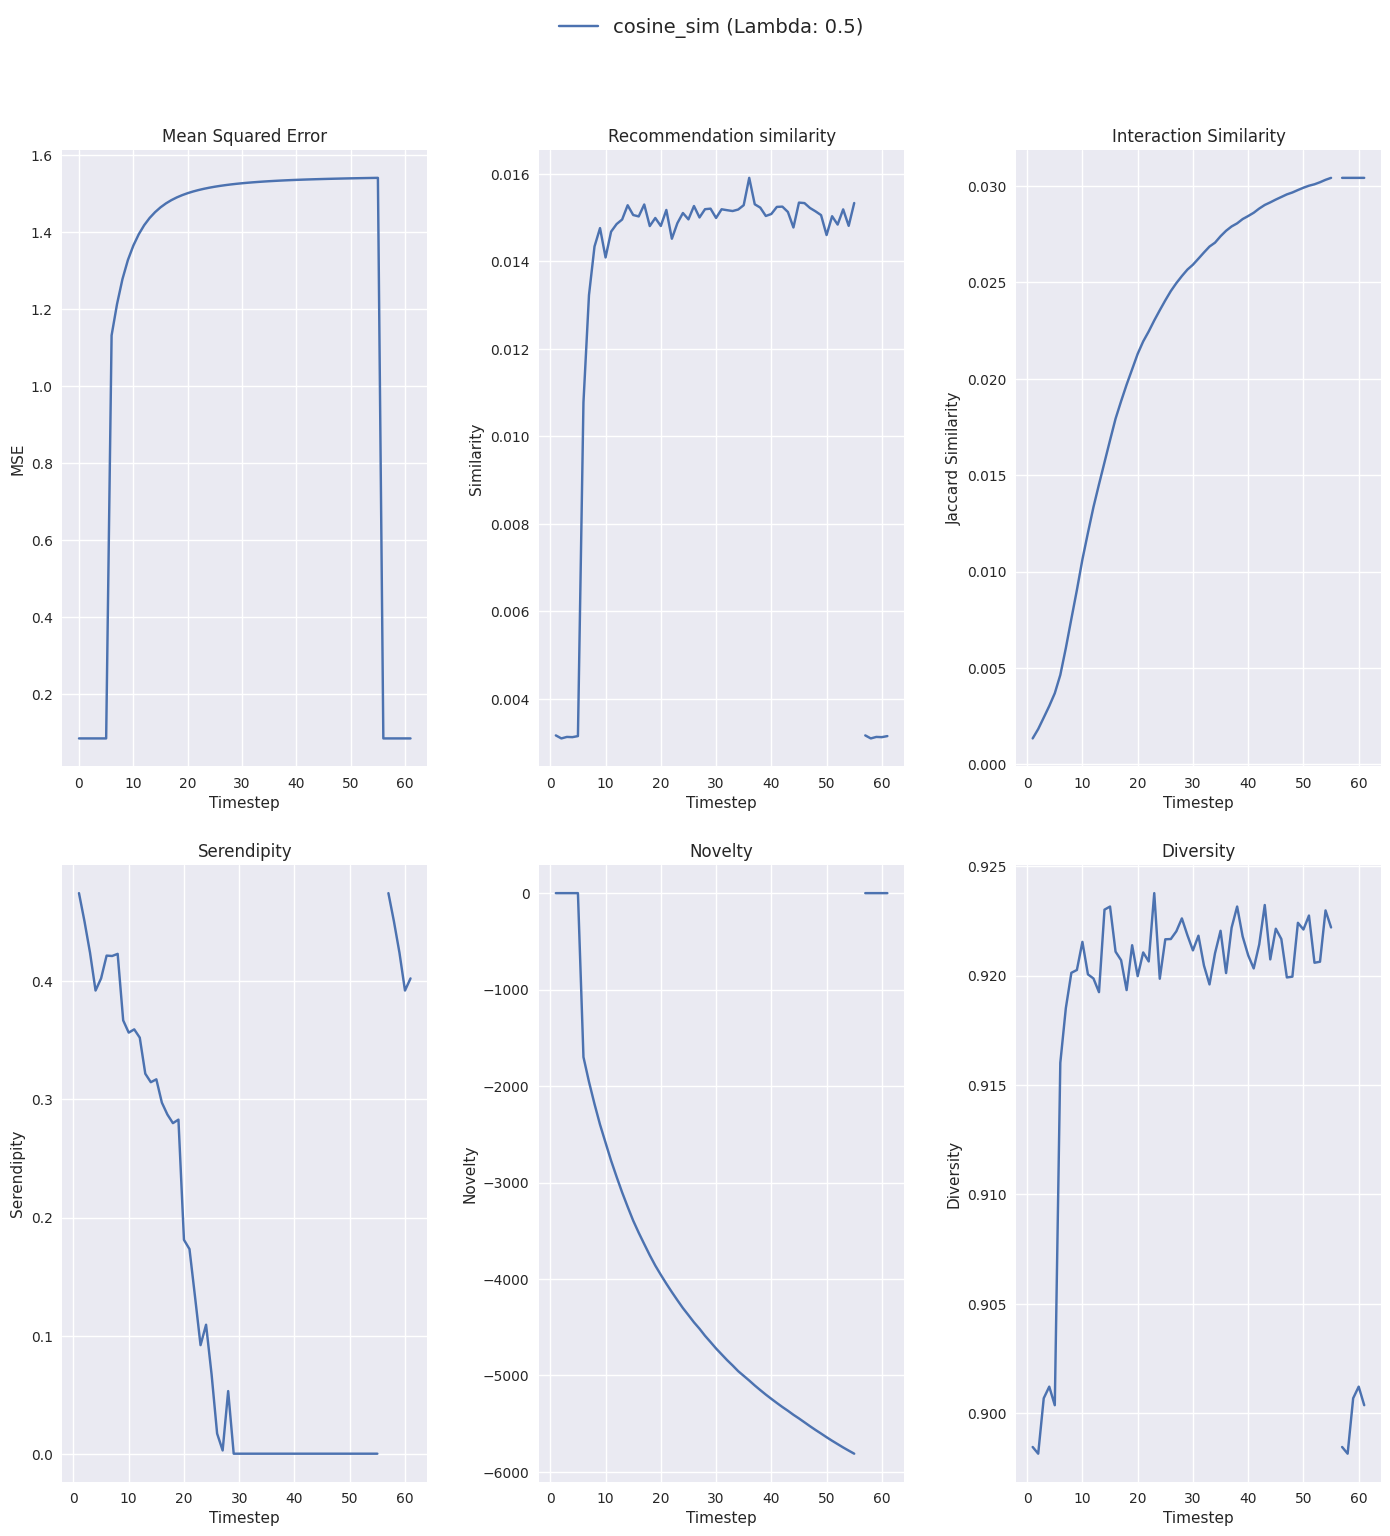

In [120]:
import src
reload(src.utils)
from src.utils import *
    
# Save measurements
measurements_dir = f'artefacts/measurements/'
file_name = f'{model_name}_measurements_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters'
measurements_path = measurements_dir + file_name
if requires_alpha:
    measurements_path += f'_{alpha}Lambda'
measurements_path += '.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
measurements_df.to_csv(measurements_path)
print('Measurements saved.')

# Create df for parametrics
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])
    
plot_measurements([measurements_df], parameters_df)